### Pre-trained SAE

In [1]:
MAX_LEN = 128
N_SAMPLE = 1000

# DOMAIN = 'Pile'
DOMAIN = 'OpenWebText2'
# DOMAIN = 'ArXiv'
# DOMAIN = 'Github'
# DOMAIN = 'Standard English (PG19)'

###############################################################

d = 768; h = 24576
title = 'GPT-2 Small' #+ f' - {DOMAIN}'
model_name = 'gpt2-small'
release = 'gpt2-small-res-jb'
sae_by_layer = {layer: f"blocks.{layer}.hook_resid_pre" for layer in range(12)}

# d = 2304; h = 16384
# title = 'Gemma Scope 2B' #+ f' - {DOMAIN}'
# model_name = 'gemma-2-2b'
# release = 'gemma-scope-2b-pt-res-canonical'
# sae_by_layer = {layer: f"layer_{layer}/width_16k/canonical" for layer in range(25)}

cfg_str = f'{title} - {DOMAIN}_length{MAX_LEN}_samples{N_SAMPLE}'

### Running Experiments

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
import torch
import random
import numpy as np
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset
import os

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [4]:
from sae_lens import SAE, HookedSAETransformer
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate

model = HookedSAETransformer.from_pretrained(model_name, device=device)
print(model.cfg)

if DOMAIN == 'Standard English (PG19)':
    dataset = load_dataset('pg19', trust_remote_code=True)["train"].select(range(N_SAMPLE))
else:
    dataset = load_dataset(
        path="NeelNanda/pile-10k",
        split="train",
        streaming=False,
    )
    if DOMAIN == 'ArXiv':
        dataset = dataset.filter(lambda example: example['meta']['pile_set_name'] == 'ArXiv')
    elif DOMAIN == 'OpenWebText2':
        dataset = dataset.filter(lambda example: example['meta']['pile_set_name'] == 'OpenWebText2')
    elif DOMAIN == 'Github':
        dataset = dataset.filter(lambda example: example['meta']['pile_set_name'] == 'Github')

token_dataset = tokenize_and_concatenate(
    dataset=dataset,
    tokenizer=model.tokenizer,
    streaming=True,
    max_length=MAX_LEN,
    add_bos_token=model.cfg.default_prepend_bos,
)

# Comment out these lines to test the entire dataset
token_dataset = token_dataset.shuffle().take(N_SAMPLE)

c:\Users\sewoo\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
HookedTransformerConfig:
{'NTK_by_parts_factor': 8.0,
 'NTK_by_parts_high_freq_factor': 4.0,
 'NTK_by_parts_low_freq_factor': 1.0,
 'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': 8.0,
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 64,
 'd_mlp': 3072,
 'd_model': 768,
 'd_vocab': 50257,
 'd_vocab_out': 50257,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': device(type='cuda'),
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.02886751345948129,
 'load_in_4bit': False,
 'model_name': 'gpt2',
 'n_ctx': 1024,
 'n_devices': 1,
 'n_heads': 12,
 'n_key_value_heads': None,
 'n_layers': 12,
 'n_params': 84934656,
 'norm

In [5]:
def test_f_tilde(z_hat, f_tilde, W_dec, b_dec):
    '''
    # W_dec.shape = (d_sae, d_model)
    # b_dec.shape = (d_model)
    '''
    z_hat = z_hat.detach().cpu().numpy()
    W = W_dec.detach().cpu().numpy() / np.linalg.norm(W_dec.detach().cpu().numpy(), axis=1, keepdims=True)
    b = (b_dec / np.linalg.norm(b_dec.detach().cpu().numpy())).detach().cpu().numpy()
    assert np.allclose(np.linalg.norm(W, axis=1), 1, atol=1e-4)
    assert np.allclose(np.linalg.norm(b), 1, atol=1e-4)
    Wf = f_tilde @ np.vstack((W, b))

    return np.allclose(z_hat, Wf, atol=1e-4)

In [6]:
saes = []
for layer in sae_by_layer.keys():
    sae, cfg_dict, sparsity = SAE.from_pretrained(
                    release=release,
                    sae_id=sae_by_layer[layer],
                    device=str(device),
                )
    saes.append(sae)

c:\Users\sewoo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sae_lens\sae.py:145: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In [7]:
import jax.numpy as jnp

save_header = True

if os.path.exists('output_csv/'+cfg_str+'.csv'):
    os.remove('output_csv/'+cfg_str+'.csv')

with torch.no_grad():
    for sequence in tqdm(token_dataset):
        tokens = sequence["tokens"].to(device) # TODO: model.run_with_cache_with_saes(prompt, saes=[sae])
        _, cache = model.run_with_cache(tokens)
        
        df_rows = []
        for layer in sae_by_layer.keys():
            sae_id = sae_by_layer[layer]

            sae, cfg_dict, sparsity = SAE.from_pretrained(
                release=release,
                sae_id=sae_id,
                device=str(device),
            )
            
            z = cache[sae.cfg.hook_name] # z, z_hat: (batch_size, seq_len, d_model)
            f = sae.encode(z) # f: (batch_size, seq_len, d_sae)
            z_hat = sae.decode(f) # == f @ sae.W_dec + sae.b_dec  # For testing
            
            for bi in range(z.shape[0]):
                bi, si = 0, -1  # one batch, last token
                ztz = z[bi][si] @ z[bi][si]  # TODO: ztz = jnp.dot(z[bi][si], z[bi][si])
                ztz_hat = z_hat[bi][si] @ z_hat[bi][si]  # TODO: bug fix - Something's different with 1-layer analysis
                
                f_norm = f[bi][si].detach().cpu().numpy() * np.linalg.norm(sae.W_dec.to(torch.float32).detach().cpu().numpy(), axis=1)
                
                l2_b = np.linalg.norm(sae.b_dec.detach().cpu().numpy())
                f_tilde = np.append(f_norm, l2_b)
                # assert test_f_tilde(z_hat[bi][si], f_tilde, sae.W_dec, sae.b_dec) # For testing
                
                df_rows.append({
                    'layer': str(layer+1), # 0-based to 1-based
                    'ztz': ztz.detach().cpu().numpy(),
                    'ftf': f_tilde @ f_tilde,
                    'norm_z': np.sqrt(ztz.detach().cpu().numpy()),
                    'norm_f': np.sqrt(f_tilde @ f_tilde),
                    'norm_z_hat': np.sqrt(ztz_hat.detach().cpu().numpy()),
                    'l_recon': np.sum(((z[bi][si] - z_hat[bi][si])**2).detach().cpu().numpy()),
                    'text': model.tokenizer.decode(sequence["tokens"].detach().cpu().numpy())[-80:].replace('\n', '<br>'), # replace for plotly hovering
                })
                
            del sae, cfg_dict, sparsity
            del z, f, ztz, z_hat
            del f_norm, l2_b, f_tilde
            
        pd.DataFrame(df_rows).to_csv('output_csv/'+cfg_str+'.csv', mode='a', header=save_header, index=False)
        save_header = False # only save header once
        
        del tokens, _, cache, df_rows
        torch.cuda.empty_cache()

100%|██████████| 1000/1000 [1:16:56<00:00,  4.62s/it]


### Read File

In [2]:
import pandas as pd
df = pd.read_csv('output_csv/'+cfg_str+'.csv')
df

,layer,ztz,ftf,norm_z,norm_f,norm_z_hat,l_recon,text
0,1,19.033733,17.208841,4.362767,4.148354,4.329874,0.013940,"lazy options of pre-packed food, even ready-ma..."
1,2,2294.855500,2104.294700,47.904650,45.872593,47.552345,18.515594,"lazy options of pre-packed food, even ready-ma..."
2,3,2822.698000,2538.373000,53.129070,50.382270,52.337627,25.221195,"lazy options of pre-packed food, even ready-ma..."
3,4,3059.020300,2596.032700,55.308410,50.951280,53.657790,67.015140,"lazy options of pre-packed food, even ready-ma..."
4,5,3719.876500,2721.176300,60.990790,52.164894,58.638123,119.373410,"lazy options of pre-packed food, even ready-ma..."
...,...,...,...,...,...,...,...,...
11995,8,11087.618000,4419.363300,105.297760,66.478294,101.564250,613.235350,faat.<br><br>Military council of Al-Bab and it...
11996,9,15839.279000,5757.351600,125.854200,75.877210,117.403480,867.575700,faat.<br><br>Military council of Al-Bab and it...
11997,10,19738.941000,7991.003400,140.495350,89.392410,130.840060,1135.564500,faat.<br><br>Military council of Al-Bab and it...
11998,11,24954.754000,13457.385000,157.970730,116.005970,147.568900,1596.998200,faat.<br><br>Military council of Al-Bab and it...


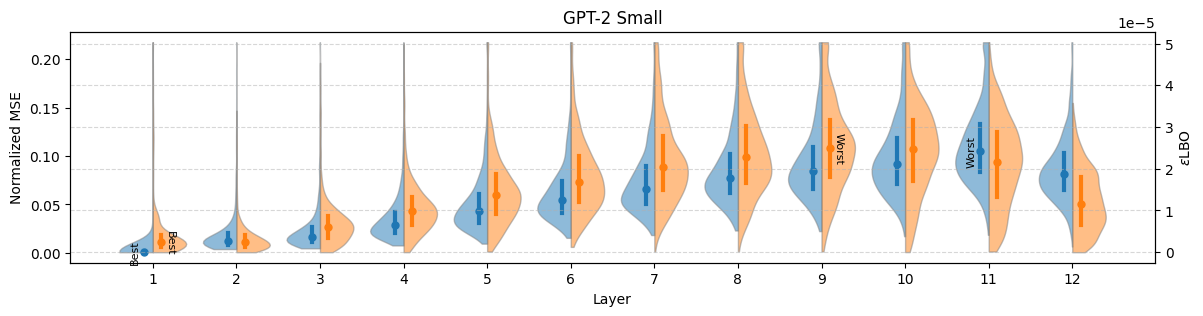

In [3]:
import matplotlib.pyplot as plt
import numpy as np

df = df.copy()
df['elbo'] = abs(df['norm_z']**2 - df['norm_f']**2) / ((h - 1) * df['norm_f']**2)
df['recon_loss'] = df['l_recon'] / (df['norm_z'] ** 2)

# A single outlier can make the violin plot like a dot.
df['recon_loss'] = df['recon_loss'].clip(
    upper=df['recon_loss'].quantile(0.99)
)
df['elbo'] = df['elbo'].clip(
    upper=df['elbo'].quantile(0.99)
)

layers = sorted(df['layer'].unique())
positions = np.arange(len(layers))

recon_medians = df.groupby('layer')['recon_loss'].median()
elbo_medians = df.groupby('layer')['elbo'].median()

recon_best = recon_medians.idxmin()
recon_worst = recon_medians.idxmax()
elbo_best = elbo_medians.idxmin()
elbo_worst = elbo_medians.idxmax()

fig, ax1 = plt.subplots(figsize=(14, 3))
ax2 = ax1.twinx()

color1 = 'C0'
color2 = 'C1'

for i, layer in enumerate(layers):
    recon_data = df[df['layer'] == layer]['recon_loss']
    elbo_data = df[df['layer'] == layer]['elbo']

    # Left =======================================================================    
    parts1 = ax1.violinplot(recon_data, positions=[positions[i]], widths=0.8,
                            showmeans=False, showmedians=False, showextrema=False)
    for pc in parts1['bodies']:
        pc.set_facecolor(color1)
        pc.set_edgecolor('gray')
        pc.set_alpha(0.5)
        m = pc.get_paths()[0].vertices
        m[:, 0] = np.minimum(m[:, 0], positions[i])  # clip right half violin

    q1, med, q3 = np.percentile(recon_data, [25, 50, 75])
    ax1.plot([positions[i]-0.1, positions[i]-0.1], [q1, q3], color=color1, lw=3)
    ax1.plot(positions[i]-0.1, med, 'o', color=color1, markersize=5)
    
    if layer == recon_best:
        ax1.text(
            positions[i]-0.15, med, 'Best',
            color='black', fontsize=8,
            ha='right', va='center',
            # bbox=dict(facecolor='white', edgecolor=color1, boxstyle='round,pad=0.2', alpha=0.5),
            rotation=90,
        )
    elif layer == recon_worst:
        ax1.text(
            positions[i]-0.15, med, 'Worst',
            color='black', fontsize=8,
            ha='right', va='center',
            # bbox=dict(facecolor='white', edgecolor=color1, boxstyle='round,pad=0.2', alpha=0.5),
            rotation=90,
        )

    # Right ======================================================================
    parts2 = ax2.violinplot(elbo_data, positions=[positions[i]], widths=0.8,
                            showmeans=False, showmedians=False, showextrema=False)
    for pc in parts2['bodies']:
        pc.set_facecolor(color2)
        pc.set_edgecolor('gray')
        pc.set_alpha(0.5)
        m = pc.get_paths()[0].vertices
        m[:, 0] = np.maximum(m[:, 0], positions[i])  # clip left half violin

    q1_e, med_e, q3_e = np.percentile(elbo_data, [25, 50, 75])
    ax2.plot([positions[i]+0.1, positions[i]+0.1], [q1_e, q3_e], color=color2, lw=3)
    ax2.plot(positions[i]+0.1, med_e, 'o', color=color2, markersize=5)

    if layer == elbo_best:
        ax2.text(
            positions[i]+0.15, med_e, 'Best',
            color='black', fontsize=8,
            ha='left', va='center',
            # bbox=dict(facecolor='white', edgecolor=color2, boxstyle='round,pad=0.2', alpha=0.5),
            rotation=270,
        )
    elif layer == elbo_worst:
        ax2.text(
            positions[i]+0.15, med_e, 'Worst',
            color='black', fontsize=8,
            ha='left', va='center',
            # bbox=dict(facecolor='white', edgecolor=color2, boxstyle='round,pad=0.2', alpha=0.5),
            rotation=270,
        )

ax1.set_xticks(positions)
ax1.set_xticklabels(layers)
ax1.set_xlabel("Layer")
ax1.set_ylabel("Normalized MSE")
ax2.set_ylabel(r"$\varepsilon$LBO")

ax1.tick_params(axis='y')
ax2.tick_params(axis='y')

plt.title(title)
plt.grid(axis='y', linestyle='--', alpha=0.5)
output_dir = f"output_plot/half_violin_bestworst_{cfg_str}"
plt.savefig(output_dir + ".pdf", dpi=300, bbox_inches='tight')
plt.show()


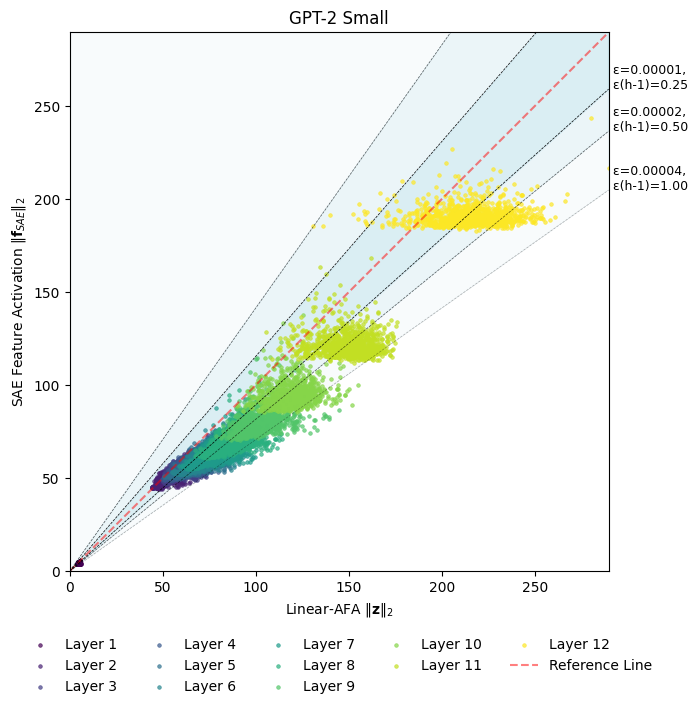

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_scatter_pyplot(x_col, y_col, x_label, y_label, show_error_bound=True):
    unique_layers = sorted(df['layer'].unique(), key=lambda x: int(x))
    n_layers = len(unique_layers)

    # Use viridis colormap
    cmap = plt.get_cmap('viridis')
    colors = [cmap(i / (n_layers - 1) if n_layers > 1 else 0.5) for i in range(n_layers)]
    layer_color_map = {layer: color for layer, color in zip(unique_layers, colors)}

    plt.figure(figsize=(7, 7))

    for layer in unique_layers:
        layer_data = df[df['layer'] == layer]
        plt.scatter(
            layer_data[x_col].astype(float),
            layer_data[y_col].astype(float),
            color=layer_color_map[layer],
            label=f'Layer {layer}',
            s=7,
            # s=10,
            # s=20,
            alpha=0.7,
            # edgecolors='black',
            linewidths=0.5,
        )

    # Add reference line
    min_val = 0
    max_val = max(df[x_col].max(), df[y_col].max())
    x_vals = np.linspace(min_val, max_val, 500)
    
    plt.plot([min_val, max_val], [min_val, max_val], linestyle='dashed', color='red', label='Reference Line', alpha=0.5)

    if show_error_bound:
        for i, ehminus1 in enumerate([0.25, 0.5, 1]):
            epsilon = ehminus1/(h-1)
            upper_slope = np.sqrt(1/(1-ehminus1)) if ehminus1 < 1 else 999
            lower_slope = np.sqrt(1/(1+ehminus1))
        
            upper_bound = upper_slope * x_vals
            lower_bound = lower_slope * x_vals

            c, s, w, a = 'black', '--', 0.5, (1, 0.66, 0.33)
            plt.fill_between(x_vals, lower_bound, upper_bound, color='lightblue', alpha=a[i]/4, zorder=-1)
            plt.plot(x_vals, lower_bound, color=c, linestyle=s, linewidth=w, alpha=a[i])
            plt.plot(x_vals, upper_bound, color=c, linestyle=s, linewidth=w, alpha=a[i])
            
            plt.text(x_vals[-1], lower_bound[-1], f' ε={epsilon:0.5f},\n ε(h-1)={ehminus1:0.2f}', 
                     fontsize=9)

    # Labels and formatting
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    if 'GPT' in title:
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=5, frameon=False) # GPT-2
    else:
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.36), ncol=5, frameon=False) # Gemma Scope

    plt.title(title)
    plt.axis('square')  # Enforce square aspect ratio
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)

    # Save and show plot
    output_dir = f"output_plot/{x_col}_{y_col}_{cfg_str}"
    plt.savefig(output_dir+'.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir+'.pdf', dpi=300, bbox_inches='tight')
    plt.show()

plot_scatter_pyplot(x_col='norm_z', y_col='norm_f', x_label='Linear-AFA $\|\mathbf{z}\|_2$', y_label='SAE Feature Activation $\|\mathbf{f}_{SAE}\|_2$', show_error_bound=True)

In [5]:
import os
import plotly.graph_objs as go

def plotly_scatter(x_col, y_col, x_label, y_label):
    unique_layers = sorted(df['layer'].unique(), key=lambda x: int(x))
    n_layers = len(unique_layers)

    from plotly.colors import sample_colorscale
    colors = sample_colorscale('Viridis', [i / (n_layers - 1) if n_layers > 1 else 0.5 for i in range(n_layers)])
    layer_color_map = {layer: color for layer, color in zip(unique_layers, colors)}

    scatter_traces = []
    for layer in unique_layers:
        layer_data = df[df['layer'] == layer]
        
        scatter_traces.append(
            go.Scatter(
                x=layer_data[x_col].astype(float),
                y=layer_data[y_col].astype(float),
                mode='markers',
                marker=dict(
                    size=5,
                    color=layer_color_map[layer],
                    opacity=0.7,
                    line=dict(width=0.5, color='black')
                ),
                name=layer.astype(str),
                text=layer_data['text'],
                customdata=layer_data[['layer']],
                hovertemplate='Layer: %{customdata[0]}<br>Input text: ...%{text}',
            )
        )

    min_val = 0
    max_val = max(df[x_col].max(), df[y_col].max())

    ref_line = go.Scatter(
        x=[min_val, max_val],
        y=[min_val, max_val],
        mode='lines',
        line=dict(color='red', dash='dash'),
        name='Reference Line',
        hoverinfo='none'
    )
    scatter_traces.append(ref_line)

    layout = go.Layout(
        title=title,
        xaxis=dict(
            title=x_label,
            showgrid=True,
            gridcolor='lightgrey',
            showline=False,
            zeroline=False,
        ),
        yaxis=dict(
            title=y_label,
            showgrid=True,
            gridcolor='lightgrey',
            showline=False,
            zeroline=False
        ),
        showlegend=True,
        width=700,
        height=700,
        legend=dict(
            xanchor='left',
            yanchor='top'
        ),
        xaxis_scaleanchor="y",
        yaxis_scaleanchor="x",
        plot_bgcolor='white',
        paper_bgcolor='white'
    )

    fig = go.Figure(data=scatter_traces, layout=layout)
    fig.update_layout(font_family='Open Serif')

    fig.show()
    fig.write_html(f"output_plot/{x_col}_{y_col}_{cfg_str}.html")
    
plotly_scatter(x_col='norm_z', y_col='norm_f', x_label='Linear-AFA = || z(x) ||', y_label='|| f̃ ||')